In [1]:
import warnings
warnings.filterwarnings('ignore')

# Module 7 Lab - Linear Regression

## Directions

1. Show all work/steps/calculations. If it is easier to write it out by hand, do so and submit a scanned PDF in addition to this notebook. Otherwise, generate a Markdown cell for each answer.
2. You must submit to **two** places by the deadline:
    1. In the Lab section of the Course Module where you downloaded this file from, and
    2. In your Lab Discussion Group, in the forum for the appropriate Module.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as np_random
import pandas as pd
import patsy
import random as py_random
import scipy.stats as stats
import seaborn as sns
import sklearn.linear_model as linear
import time

sns.set(style="darkgrid")

# Random seed
SEED = 1476410452

# [1] 
def restyle_boxplot(patch):
    ## change color & linewidth of the whiskers
    for whisker in patch['whiskers']:
        whisker.set(color="#000000", linewidth=1)
    
    ## change color & linewidth of the caps
    for cap in patch['caps']:
        cap.set(color="#000000", linewidth=1)
    
    ## change color & linewidth of the medians
    for median in patch['medians']:
        median.set(color="#000000", linewidth=2)
    
    ## change the style of fliers and their fill
    for flier in patch['fliers']:
        flier.set(marker='o', color='#000000', alpha=0.2)

# [1]
# Box & Whiskers plot
def plot_boxplots(data):
    figure = plt.figure(figsize=(20,6))
    labels = ['{0} Samples'.format(len(data))]

    # Plot without jitter
    axes = figure.add_subplot(1,2,1)
    axes.set_title("Box & Whiskers")
    patch = axes.boxplot(data, labels=labels, showfliers=True, patch_artist=True)
    restyle_boxplot(patch)
    
    # Plot with jitter
    axes = figure.add_subplot(1,2,2)
    axes.set_title("Box & Whiskers with jitter")
    patch = axes.boxplot(data, labels=labels, showfliers=True, patch_artist=True)
    restyle_boxplot(patch)
    x = np.random.normal(1, 0.01, size=len(data))
    axes.plot(x, data, 'o', alpha=0.4)
    plt.show()

# [1]
# Simple scatter plot of X & Y    
def scatter_plot_X_Y(X, Y, title):
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1,1,1)
    axes.scatter(X, Y, color='steelblue', alpha=0.5)
    axes.set_title(title)
    axes.set_ylabel('Y')
    axes.set_xlabel('X')    

    
# Printing summary stats
def print_summaries(data):
    print( "---------------------------------")
    print( "Evaluating {0} samples:".format(len(data)))
    print( "Mean: {0}".format(np.mean(data)))
    print( "Standard Deviation: {0}".format(np.std(data)))
    
    # Coeffecient of Variation
    cov = abs(np.std(data)/np.mean(data))
    print( "Coeffecient of Variation: {0}".format(cov))
    print( "---------------------------------")

# Generating uniform random samples 
def generate_uniform_samples(low, high, size):
    return np.random.uniform(low=low, high=high, size=size)

# Samples from a normal distribution
def generate_normal_samples(mean, stddev, size):
    return np.random.normal(loc=mean, scale=stddev, size=size)

# For generating noise 
def generate_epsilon(stddev, size):
    # get epsilon(noise)
    noise = np.random.normal(loc=0, scale=stddev, size=size)
    return noise

## Linear Regression

Several times this semester we have worked backwards from the technique we want to use to generate data that fits the technique and then evaluate the technique. We're going to do this again for Linear Regression.

To a certain extent, the training wheels are coming off. I'll get you started but your performance on this Lab will be assessed based on the thoroughness and creativity that you bring to the task. You should feel free to write helper functions that take away some of the repetive work.

As we've noted before, this is the simplest linear model:

$Y = \beta_0 + \epsilon$

where $\beta_0$ is a constant and $\epsilon$ is distributed $N(0, \sigma)$. There are two ways we could generate data for this model. First, we could recognize that this is just $N(\beta_0, \sigma)$ and just generate data directly from the normal distribution as we did before. Second, we could break it into pieces.

I want you to break it into pieces.

**1\. Generate 100 data points from the above model using $\beta_0 = 32.5$ and $\sigma=1.29$. Make a Boxplot of the data and calculate mean, standard deviation and coefficient of variation.**

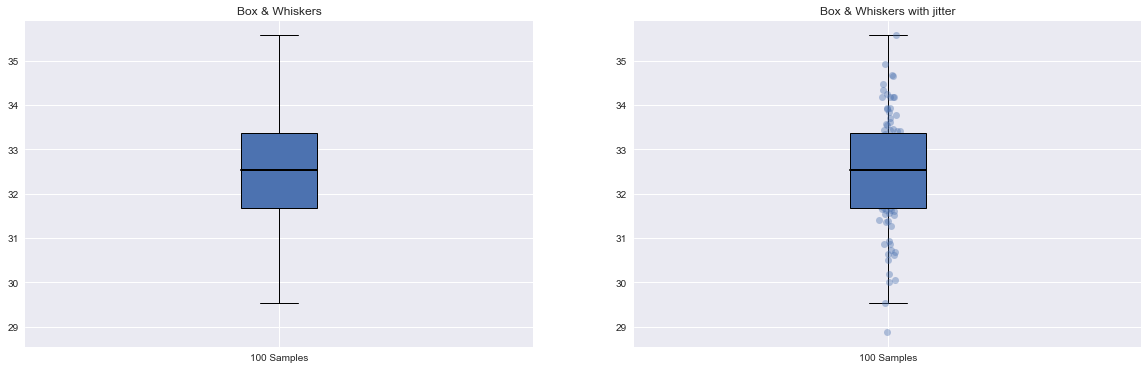

---------------------------------
Evaluating 100 samples:
Mean: 32.53256554857297
Standard Deviation: 1.2418188935823455
Coeffecient of Variation: 0.03817156355923542
---------------------------------


In [3]:
# Set the seed
py_random.seed(SEED)
np.random.seed(SEED)

# Calculate simple linear model (slm)
beta_0 = 32.5
noise = generate_epsilon(1.29, 100)
slm = [beta_0 + ep for ep in noise]

# Plots & Summaries
plot_boxplots(slm)
print_summaries(slm)

Now, that isn't a very interesting model. We're trying to work towards multivariate models and away from univariate statistics. This means we need to introduce predictors both numerical and categorical (including all the other names they are known by).

$Y = \beta_0 + \beta_1 X_1 + \epsilon$

is the next simplest model we can build *and* do linear regression on. There are a number of ways to go about this as well. I'm going to take a few shortcuts and then make some suggestions for you to investigate.

It doesn't really matter what distribution $X_1$ comes from because the normality is going to come from $\epsilon$. Therefore, you can simply make up, your mind, what you think you want $X_1$ to be (positive? negative? 1000s? 0.001s?) and what you want $\beta_1$ to be (greater than 1, less than 1, etc).

**2\. Generate 250 observations from the following relation:**

$Y = 32.5 + 2.3 X_1 + \epsilon$

where $X_1$ is *uniformly* randomly distributed from (100, 200) and $\epsilon=5.0$.

In [4]:
# Set the seed
py_random.seed(SEED)
np.random.seed(SEED)

# Get components of our linear model
beta_0 = 32.5
beta_1 = 2.3
X1 = generate_uniform_samples(low=100, high=200, size=250)
epsilon = generate_epsilon(stddev=5.0, size=250)
Y = [beta_0 + (beta_1 * x) + e for x,e in zip(X1, epsilon)]

# Pack them into a Pandas DataFrame for ease of use
data = pd.DataFrame.from_records(data=zip(Y,X1), columns=['Y','X1'])

**3\. Apply the Bootstrap version of LM from the lecture to this data and intepret the coefficients, $R^2$, error of the regression. Plot (Y, X). Plot the residuals. Make any comments/observations that seem appropriate.**

Regression:	Y ~ X1
# of Samples:	100
------------------
Intercept:	34.12026820289852,	95% CI:[30.695786212441497, 37.046654372536636]
X1:	2.2886890550218086,	95% CI:[2.2687194511155893, 2.309348781689109]
------------------
Sigma:	4.848112170603462.	95% CI: [ 4.30886377  5.20782485]
R^2:	0.9947899864308785.	95% CI: [ 0.99354929  0.9959947 ]
------------------


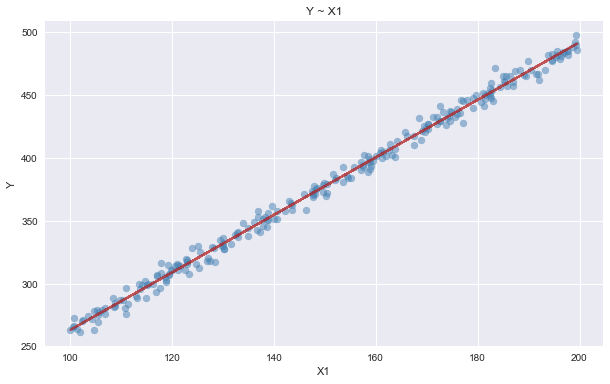

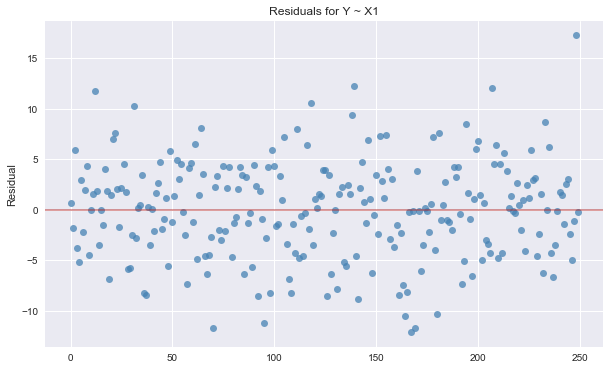

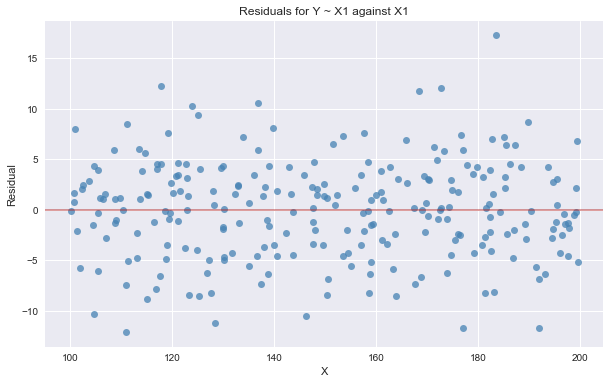

In [5]:
# [1]
# Run the linear model
def lm(formula, data=None):

    # Run the model (Note: Is that fit_intercept=False call correct?  Don't we want an intercept?)
    y, X = patsy.dmatrices(formula, data)
    model = linear.LinearRegression(fit_intercept=False).fit(X,y)
    
    # Describe our result
    result = {}
    result['samples'] = data.shape[0]
    result['formula'] = formula
    result['coefficients'] = model.coef_[0]

    # Find the residuals and error
    y_hat = model.predict(X)
    result['residuals'] = y - y_hat
    
    # Standard Error
    sum_squared_error = sum([e**2 for e in result['residuals']])[0]
    n = len(result['residuals'])
    k = len(result['coefficients'])
    result['sigma'] = np.sqrt(sum_squared_error / (n - k))
    
    # R squared mesure of error
    result['R^2'] = model.score(X,y)
    return result
    
# [1]
# Bootstraps a Linear Model
def bootstrap_lm(formula, data, samples=100):
    
    # Random index
    def randint():
        py_random.randint(0, len(data-1))
    
    # Resampling
    rs = []
    coefficients = []
    sigmas = []
    for i in range(samples):
        resampling_indices = [i for i in [py_random.randint(0, len(data-1)) for _ in range(len(data))]]
        resampled = data.loc[resampling_indices]
        result = lm(formula, data=resampled)
        
        # store results
        rs.append(result['R^2'])
        coefficients.append(result['coefficients'])
        sigmas.append(result['sigma'])
        
        
    # Results of bootstrap
    results = {}
    results['formula'] = formula
    variables = ['Intercept'] + formula.split('~')[1].split('+')
    variables = [variable.strip() for variable in variables]
    results['variables'] = variables
    results['samples'] = samples
    results['resampled_sigma'] = pd.Series(sigmas, name='sigma')
    results['resampled_R^2'] = pd.Series(rs, name='R^2')
    results['resampled_coefficients'] = pd.DataFrame(coefficients, columns=variables)
    
    # Get a single sample of residuals, coefficients, sigma & R^2 
    # for display purposes
    result = lm(formula, data=data)
    results['residuals'] = result['residuals']
    results['coefficients'] = result['coefficients']
    results['sigma'] = result['sigma']
    results['R^2'] = result['R^2']
    
    # Done
    return results
        
# Print the bootstrap fit
def print_bootstrap_fit(results):
    print( "Regression:\t{0}".format(results['formula']))
    print( "# of Samples:\t{0}".format(results['samples']))
    print( "------------------")
    
    # 95% Confidence intervals for coefficients
    coef_bounds = results['resampled_coefficients'].quantile([0.025, 0.975])
    coef_bounds = coef_bounds.transpose()
    coef_bounds = coef_bounds.values.tolist()
    for var, coef, bound in zip(results['variables'], results['coefficients'], coef_bounds):
        print( "{0}:\t{1},\t95% CI:{2}".format(var, coef, bound))
    print( "------------------")
    
    # 95% Confidence intervals for error measures
    sigma_bounds = stats.mstats.mquantiles(results['resampled_sigma'], [0.025, 0.975])
    print( "Sigma:\t{0}.\t95% CI: {1}".format(results['sigma'], sigma_bounds))

    rs_bounds = stats.mstats.mquantiles(results['resampled_R^2'], [0.025, 0.975])
    print( "R^2:\t{0}.\t95% CI: {1}".format(results['R^2'], rs_bounds))
    print( "------------------")

    
# Scatter plot our model with coefficients
def scatter_plot_lm(Y, intercept, X1, beta_1, title):
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1,1,1)
    axes.scatter(X1, Y, color='steelblue', alpha=0.5)
    axes.plot(X1, [intercept + beta_1 * x for x in X1 ], '-', color='firebrick', alpha=0.75)
    axes.set_title(title)
    axes.set_ylabel('Y')
    axes.set_xlabel('X1')
    

# Plot residuals
def scatter_plot_residuals(residuals, title, X=None):
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1,1,1)
    
    # Simple scatter plot of the residuals
    if X is None:
        axes.plot(range(0, len(residuals)), residuals, 'o', color='steelblue', alpha=0.75)
    # Plot residuals against X
    else:
        axes.plot(X, residuals, 'o', color='steelblue', alpha=0.75)
        axes.set_xlabel('X')

    axes.axhline(y=0.0, c='firebrick', alpha=0.5)
    axes.set_title(title)
    axes.set_ylabel('Residual')

    

# Run experiment
np.random.seed(SEED)
py_random.seed(SEED)

results = bootstrap_lm("Y ~ X1", data)
print_bootstrap_fit(results)
intercept = results['coefficients'][0]
beta_1 = results['coefficients'][1]
scatter_plot_lm(X1=data['X1'], beta_1=beta_1, Y=data['Y'], intercept=intercept, title=results['formula'])
scatter_plot_residuals(residuals = results['residuals'], title='Residuals for {0}'.format(results['formula']))

title = 'Residuals for {0} against {1}'.format(results['formula'], 'X1')
scatter_plot_residuals(residuals=results['residuals'], X=data['X1'], title=title)

**Observations**:
The summary statistics for our model show very tight 95% confidence intervals with respect to the intercept $\beta_0$ and coefficient of $X_1$, $\beta_1$. Specifically, the original $\beta_1$ for data generation was 2.3 and our model is showing ~2.288 with a 95% CI spread of only .0394, so only off by 1 to 2%.  Interpreting the $R^2$ value of .994 indicates that our model can explain ~99% of the variance in Y. The reported standard error $\hat{\sigma}$ of 4.8 means we can expect our predictions to be accurate within 4.8 points ~2/3rds of the time, or up to 5.32 points based on the upper bound of the 95% Confidence Interval calculated. All of these might be interpreted as indicating our model is _very good_.

The X,Y plot demonstrates just how minimal the variance is in Y, as well as how accurate (centered) the linear relationship produced by our regression model really is. There appear to be equal amounts of Y above & below the line. Our residual plots show a uniform 'randomness', with similar volumes of positive & negative residuals. The residual pot against $X_1$ shows no obvious correlation, indicating that our model is not under nor over predicting. 

--------

Now this is where I set you off on your own.  You must create and recover 5 different models, providing exactly the same results and discussion as above (bootstrap, interpret coefficients, $R^2$, error of the regression, Plot each (Y,X) and Plot residuals.

There are a large number of things you can choose from:

1. Increase $\epsilon$.
2. Add polynomial terms to the real model but both include and exclude them from your model. In this case, you would add both $X_2 = X_2$ and $X_3 = X_2^2$ to the function you use to generate the data but you would examine what happens when you build a model only with $X_2 = X_2$ in it and then do the model with $X_3 = X_2^2$.
3. ...

Think back to the lecture and review the notebook. Look at things you're supposed to do or not do. Make data that demonstrates what happens when you don't do it!

Experiment #1.

We're going to increase $\epsilon$ for this model to use $\sigma = 25.0$.

Regression:	Y ~ X1
# of Samples:	100
------------------
Intercept:	40.60134101449328,	95% CI:[23.478931062207437, 55.23327186268316]
X1:	2.2434452751090372,	95% CI:[2.1435972555779457, 2.3467439084455526]
------------------
Sigma:	24.2405608530173.	95% CI: [ 21.54431886  26.03912427]
R^2:	0.8800749901828699.	95% CI: [ 0.85363214  0.90542513]
------------------


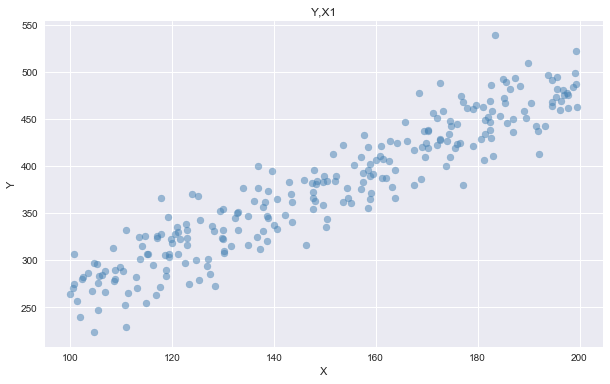

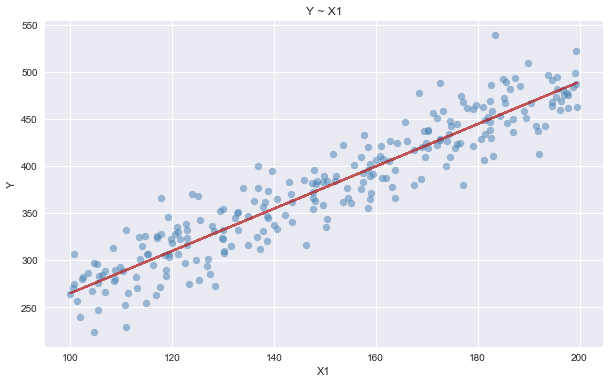

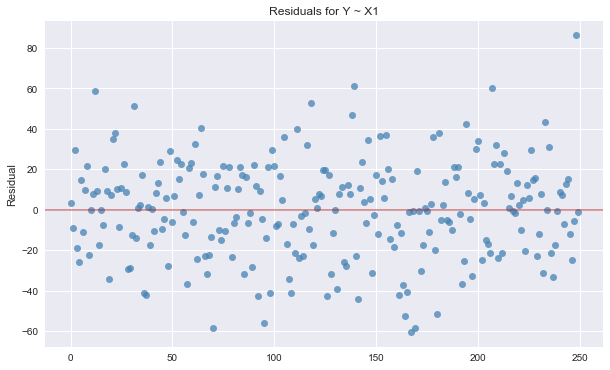

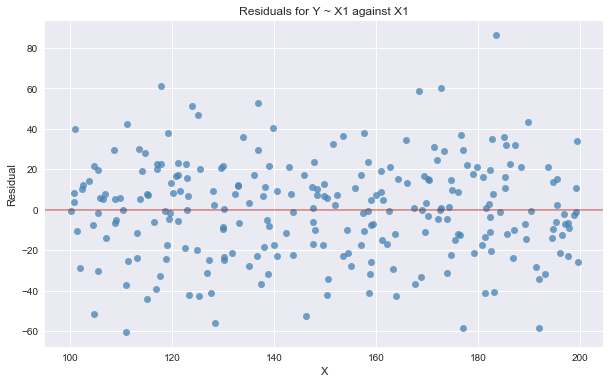

In [6]:
# Experiment 1
def experiment_1(epsilon_stddev):
    
    # Betas for our model
    beta_0 = 32.5
    beta_1 = 2.3
    
    # Generate initial sample data
    X1 = generate_uniform_samples(low=100, high=200, size=250)
    epsilon = generate_epsilon(stddev=epsilon_stddev, size=250)
    Y = [beta_0 + (beta_1 * x) + e for x,e in zip(X1, epsilon)]
    data = pd.DataFrame.from_records(data=zip(Y,X1), columns=['Y','X1'])

    # Run the bootstrap
    results = bootstrap_lm(formula='Y ~ X1', data=data)
    print_bootstrap_fit(results)

    intercept = results['coefficients'][0]
    beta_1 = results['coefficients'][1]
    scatter_plot_X_Y(X=data['X1'], Y=data['Y'], title = 'Y,X1')
    scatter_plot_lm(X1=data['X1'], beta_1=beta_1, Y=data['Y'], intercept=intercept, title=results['formula'])
    scatter_plot_residuals(residuals = results['residuals'], title='Residuals for {0}'.format(results['formula']))

    title = 'Residuals for {0} against {1}'.format(results['formula'], 'X1')
    scatter_plot_residuals(residuals=results['residuals'], X=data['X1'], title=title)
    
    
# Set the seed
np.random.seed(SEED)
py_random.seed(SEED)

# Get components of our linear model
experiment_1(epsilon_stddev=25)

**Observations**:

Increasing the noise ($\epsilon$) in our data has the net effect of adding a lot more uncertainty to the regression model produced. The 95% Confidence Interval for the intercept has expanded considerably, now covering a 31.4 point spread. The estimate of $\beta_1$ is now 2.24 with a 95% CI spanning .21 points, so the predicted coefficient is now up to about ~9% off from the actual value (2.3) used to generate the data. The reported standard error $\hat{\sigma}$ of 24.24 shows how the increase in $\epsilon$ has contributed to a loss of accuracy in the model, where its predictions could now be up to 26.35 points off based on the 95% CI.  Finally the $R^2$ 95% CI has dropped to where the model may be considered 88% accurate 85-90% of the time.

The X,Y plot shows the increased variance of Y, but that our regression line still fits similarly to the original experiment - there is just a lot more noise in play.  The residual plots still indicate our model is not over, nor under predicting. 

--------

Experiment #2.

Add in the additional term $X_2$ to the original model as follows:

$Y = 32.5 + 2.3 X_1 + 4 X_2 + \epsilon$

where:
- $X_2$ is normally distributed with $\mu=100$, $\sigma$=10
- $X_1$ and $\epsilon$ remain as they were originally defined

Start by intentionally omitting $X_2$ from your model, then introducing it.  What do you observe?  

Regression:	Y ~ X1
# of Samples:	100
------------------
Intercept:	498.0933405049483,	95% CI:[361.3422008809524, 615.0601759366921]
X1:	1.8453353863232205,	95% CI:[1.0467224881269663, 2.674837423388932]
------------------
Sigma:	194.34614467250518.	95% CI: [ 172.77424952  208.8889246 ]
R^2:	0.07170494107993375.	95% CI: [ 0.01910411  0.14841828]
------------------


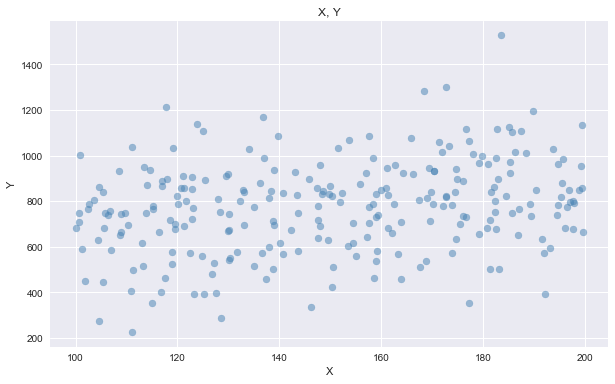

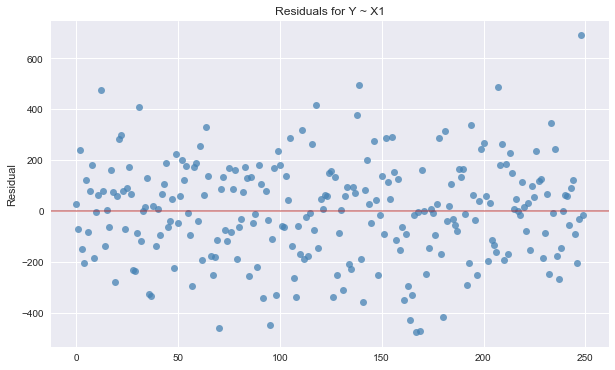

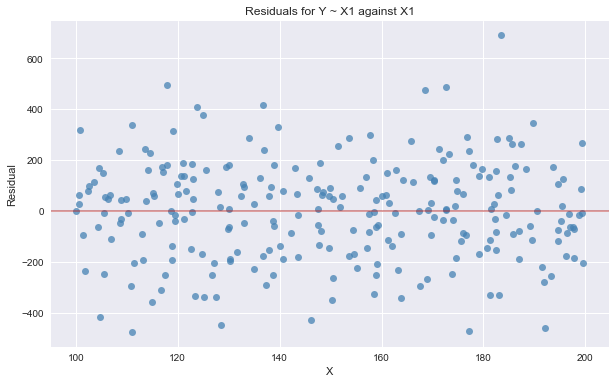

In [7]:
# Generate the data
def experiment_2_data():
    # Betas for our model
    beta_0 = 32.5
    beta_1 = 2.3
    beta_2 = 4
    
    # Generate initial sample data
    X1 = generate_uniform_samples(low=100, high=200, size=250)
    X2 = generate_normal_samples(mean=100, stddev=50, size=250)
    epsilon = generate_epsilon(stddev=5, size=250)
    Y = [beta_0 + (beta_1 * x1) + (beta_2 * x2) + e for x1,x2,e in zip(X1, X2 , epsilon)]
    data = pd.DataFrame.from_records(data=zip(Y,X1,X2), columns=['Y','X1', 'X2'])
    return data

def experiment_2_no_X2(data):
    
    # Run the bootstrap
    results = bootstrap_lm(formula='Y ~ X1', data=data)
    print_bootstrap_fit(results)

    intercept = results['coefficients'][0]
    beta_1 = results['coefficients'][1]
    scatter_plot_X_Y(X=data['X1'], Y=data['Y'], title='X, Y')
    scatter_plot_residuals(residuals = results['residuals'], title='Residuals for {0}'.format(results['formula']))
    title = 'Residuals for {0} against {1}'.format(results['formula'], 'X1')
    scatter_plot_residuals(residuals=results['residuals'], X=data['X1'], title=title)
    
# Set the seed
np.random.seed(SEED)
py_random.seed(SEED)

# Run experiments
data = experiment_2_data()
experiment_2_no_X2(data)

**Observations**:
It is clear that by omitting a variable from our model ($X_2$) the model reflects that there is something unaccounted for going on in the relationship between Y and its variable(s). The 95% Confidence Intervals for the intercept and $\beta_1$ are quite broad respectively.  $\beta_1$ (coefficient of $X_1$) is estimated at 1.84, but the range of the 95% CI says its +/- 45%.  Our standard error $\hat{\sigma}$ says our predictions for Y could be +/- 194 points, which is quite broad.  Finally, the $R^2$ is only 7%.  These are all strong indicators that our model is missing some relationship.

Regression:	Y ~ X1 + X2
# of Samples:	100
------------------
Intercept:	32.42067733551998,	95% CI:[28.91069687623132, 36.04496919569216]
X1:	2.298612176410037,	95% CI:[2.2809208009212734, 2.3176358293552948]
X2:	4.00741751428137,	95% CI:[3.991605783411834, 4.021133071581353]
------------------
Sigma:	4.920520871563634.	95% CI: [ 4.58256492  5.27671141]
R^2:	0.9994073454699639.	95% CI: [ 0.99927444  0.99954606]
------------------


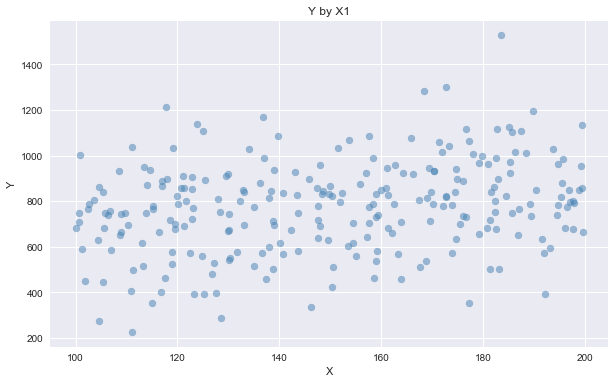

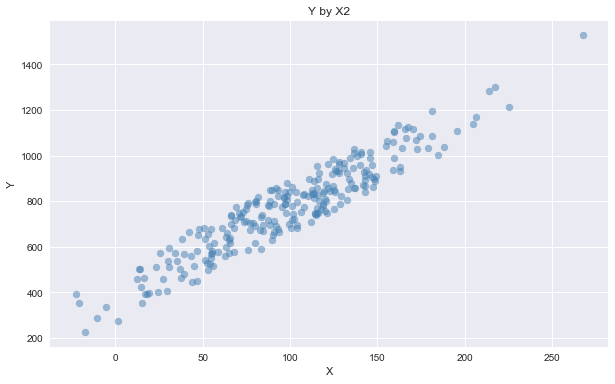

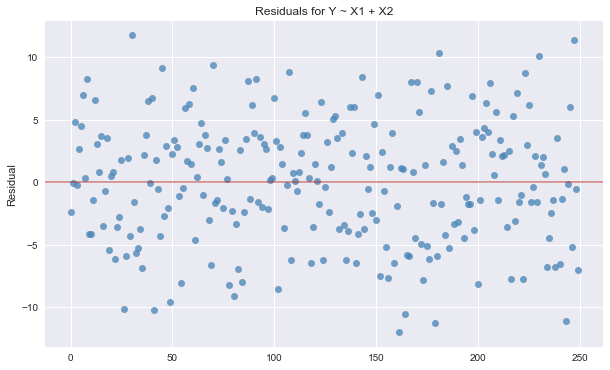

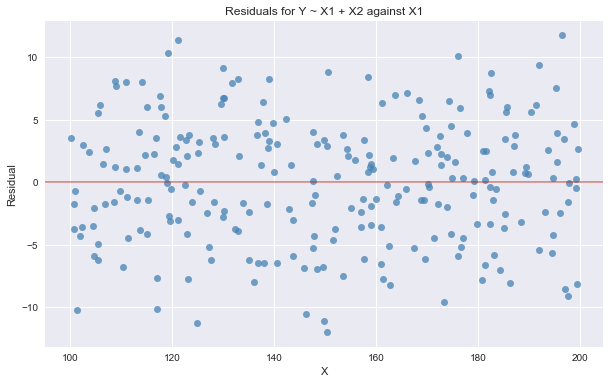

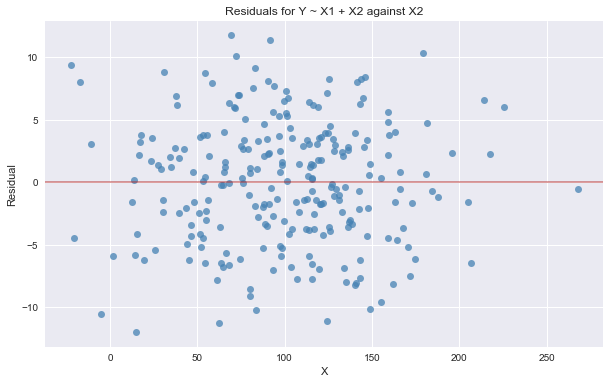

In [8]:
def experiment_2(data):
    
    # Run the bootstrap
    results = bootstrap_lm(formula='Y ~ X1 + X2', data=data)
    print_bootstrap_fit(results)
    formula = results['formula']
    residuals = results['residuals']
    scatter_plot_X_Y(X=data['X1'], Y=data['Y'], title='Y by X1')
    scatter_plot_X_Y(X=data['X2'], Y=data['Y'], title='Y by X2')
    scatter_plot_residuals(residuals=residuals, title='Residuals for {0}'.format(formula))
    scatter_plot_residuals(residuals=residuals, X=data['X1'], title='Residuals for {0} against {1}'.format(formula, 'X1'))
    scatter_plot_residuals(residuals=residuals, X=data['X2'], title='Residuals for {0} against {1}'.format(formula, 'X2'))
    
# Set the seed
np.random.seed(SEED)
py_random.seed(SEED)

# Run experiments
experiment_2(data)  

**Observations**:
The (re)introduction of $X_2$ into the model shows what we would hope to see - a marked increase in the model's accuracy.  The 95% CI for intercept and $B_1$ has improved significantly, spanning a range of only a few percentage points off the actual value. The standard error $\hat{\sigma}$ now indicates only ~5 point deviation between real and predicted values of Y.  The $R^2$ is greatly improved, up to 99%, providing a strong indicator of a good model.

It is interesting to note that in both versions of the expirment, the residuals showed no correlation to $X_1$ despite the absence of $X_2$ in the first run.  This would indicate that whatever value was missing - as indicating by the fit results - it was not related in any manner to $X_1$, otherwise we might have seen some correlation effect. 

------

Experiment #3.

Re-run experiment #2, but change $X_2$ to be a function of $X_1$, specifically $X_2 = X_1^2$.  That gives us:

$Y = 32.5 + 2.3 X_1 + 4 X_1^2 + \epsilon$

Start by omitting $X_2$ from your model, then omit only $X_1$ (re-introduce $X_2$).  What do you observe?

Regression:	Y ~ X1
# of Samples:	100
------------------
Intercept:	-86643.13247970246,	95% CI:[-88603.81002855068, -84136.17267255633]
X1:	1202.801529991601,	95% CI:[1186.567741122482, 1214.0914699479304]
------------------
Sigma:	2972.780428994874.	95% CI: [ 2712.66283987  3161.99096741]
R^2:	0.9929207374464875.	95% CI: [ 0.99203325  0.99368537]
------------------


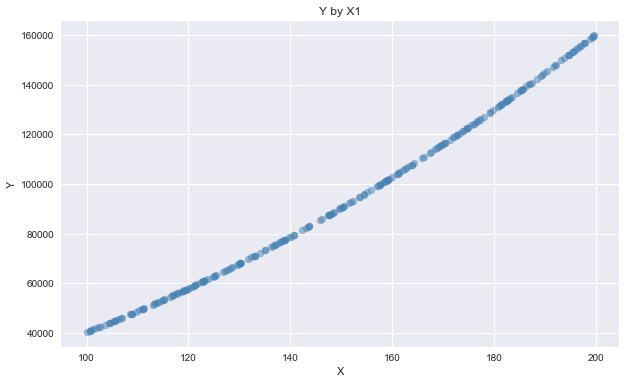

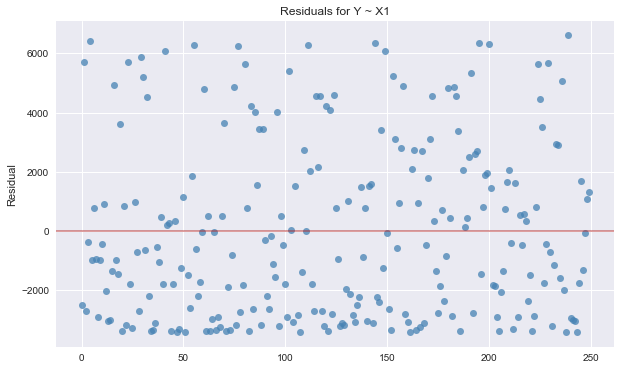

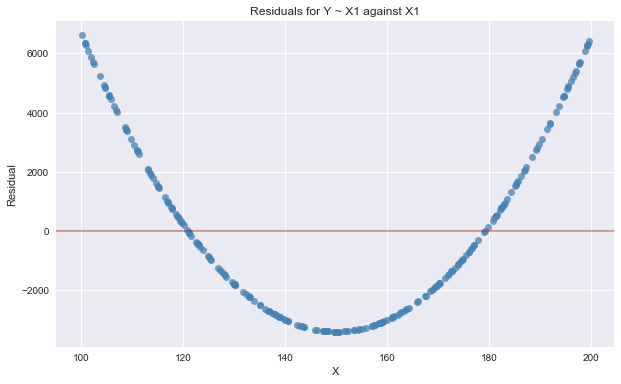

In [9]:
# Generate the data
def experiment_3_data():
    # Betas for our model
    beta_0 = 32.5
    beta_1 = 2.3
    beta_2 = 4
    
    # Generate initial sample data
    X1 = generate_uniform_samples(low=100, high=200, size=250)
    X2 = X1**2
    epsilon = generate_epsilon(stddev=5, size=250)
    Y = [beta_0 + (beta_1 * x1) + (beta_2 * x2) + e for x1,x2,e in zip(X1, X2 , epsilon)]
    data = pd.DataFrame.from_records(data=zip(Y,X1,X2), columns=['Y','X1', 'X2'])
    
    return data

# Omit X2
def experiment_3_no_X2(data):
    
    # Run the bootstrap
    results = bootstrap_lm(formula='Y ~ X1', data=data)
    print_bootstrap_fit(results)

    # Plot residuals
    scatter_plot_X_Y(X=data['X1'], Y=data['Y'], title='Y by X1')
    scatter_plot_residuals(residuals = results['residuals'], title='Residuals for {0}'.format(results['formula']))
    title = 'Residuals for {0} against {1}'.format(results['formula'], 'X1')
    scatter_plot_residuals(residuals=results['residuals'], X=data['X1'], title=title)
    
def experiment_3_no_X1(data):
    
    # Run the bootstrap
    results = bootstrap_lm(formula='Y ~ X2', data=data)
    print_bootstrap_fit(results)
    
    # Plot residuals
    scatter_plot_X_Y(X=data['X2'], Y=data['Y'], title='Y by X2')
    scatter_plot_residuals(residuals = results['residuals'], title='Residuals for {0}'.format(results['formula']))
    title = 'Residuals for {0} against {1}'.format(results['formula'], 'X2')
    scatter_plot_residuals(residuals=results['residuals'], X=data['X2'], title=title)
   

# Set random seed
np.random.seed(SEED)
py_random.seed(SEED)
    
# Run experiments
data = experiment_3_data()
experiment_3_no_X2(data)

**Observations**:
Omitting $X_2$ from model produces very pronounced heteroskedacity in the residuals plotted against $X_1$, where we're significantly over-predicting Y for low & high values of $X_1$ and under-predicting it in the middle.  We know then that there is more than just 'noise' in the data, and that we don't fully understand $Y$'s relationship to $X_1$.  We also have a very high $\hat{\sigma}$ indicating a lot of unexplained variance in $Y$. 

Regression:	Y ~ X2
# of Samples:	100
------------------
Intercept:	200.63732780282587,	95% CI:[197.67638084130925, 203.21214086542489]
X2:	4.007571275650378,	95% CI:[4.007474487827812, 4.007687211166308]
------------------
Sigma:	7.4617156774991855.	95% CI: [ 6.74716488  7.89638794]
R^2:	0.999999955399498.	95% CI: [ 0.99999995  0.99999996]
------------------


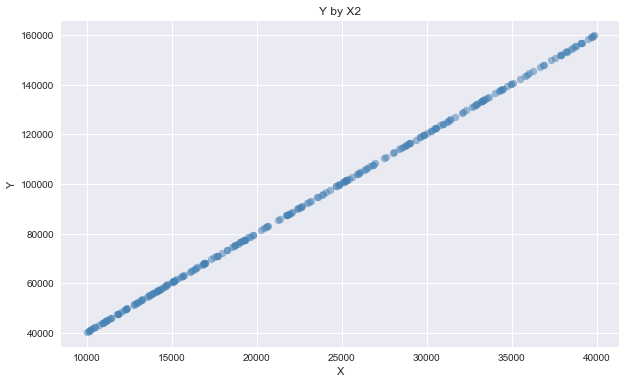

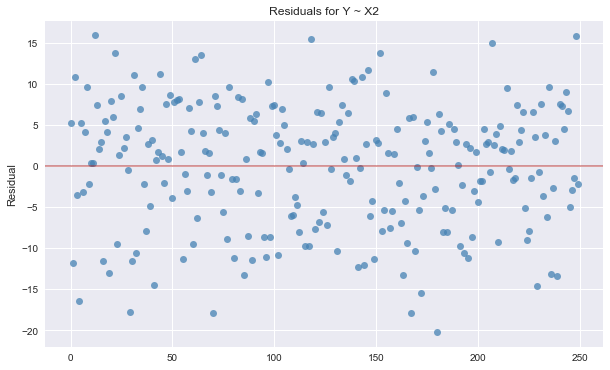

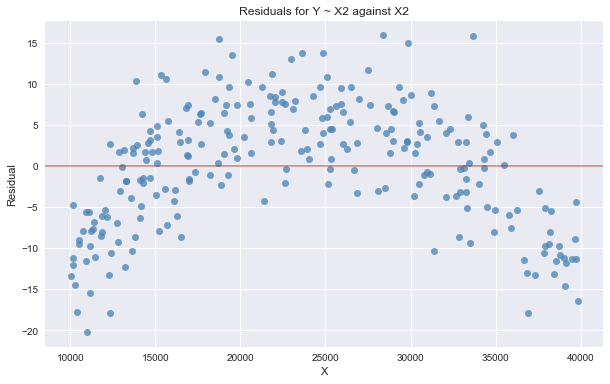

In [10]:
# Set random seed
np.random.seed(SEED)
py_random.seed(SEED)

# Run experiment
experiment_3_no_X1(data)

**Observations**:
Omitting $X_1$ from the model shows a significantly reduced $\hat{\sigma}$ compared to when $X_2$ was eliminated, highlighting how $X_2$ has a much larger effect on Y.  Still, despite having what one might consider a _good_ model based on the $R^2$ of .99 and $\hat{\sigma}$ = 7.4 with their respectively tightly bound 95% CI's, the residual plots continue to show $\sigma$ is not just random noise, but that we're missing a relationship. 

-------

Experiment #4.

Consider a different relationship where $X_1$ and $X_2$ have a multiplicative effect as $Y = 32.5 + 2.3 (X_1 * X_2) + \epsilon $, where:

- $X_1$ is uniformly randomly distributed from (100, 200)
- $X_2$ is uniformly randomly distributed from (-100, 100)
- $\epsilon$ = 5

Generate $Y$ but construct your first models using ONLY $X_1$,  then using an additive relationship between $X_1$ and $X_2$ (that is $Y \sim X_1 + X_2$). What do you observe? Is a possible relationship between $X_1$ and $X_2$ visible?

Finally, see if you can uncover the model by introducing a predictor $X_3$ = $X_1 * X_2$,  with $Y \sim X_3$.


Regression:	Y ~ X1
# of Samples:	100
------------------
Intercept:	2698.505431126563,	95% CI:[-6904.585718136148, 17732.823733552737]
X1:	-17.651155242030867,	95% CI:[-125.60901991894342, 53.655814467414245]
------------------
Sigma:	21242.29488852549.	95% CI: [ 19515.99189612  22347.10442562]
R^2:	0.0005912223534429994.	95% CI: [  1.77629939e-06   2.89162021e-02]
------------------


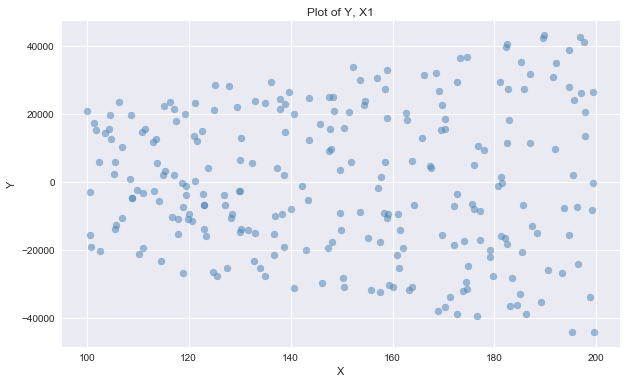

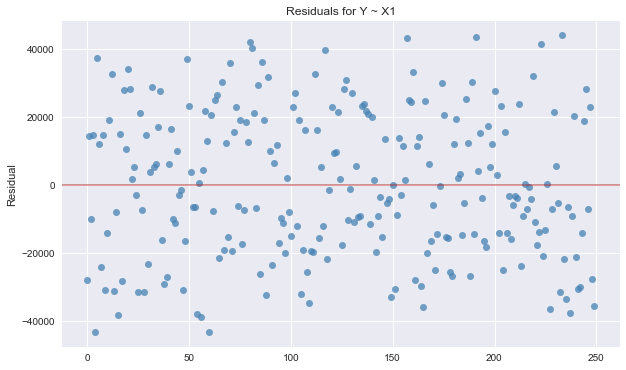

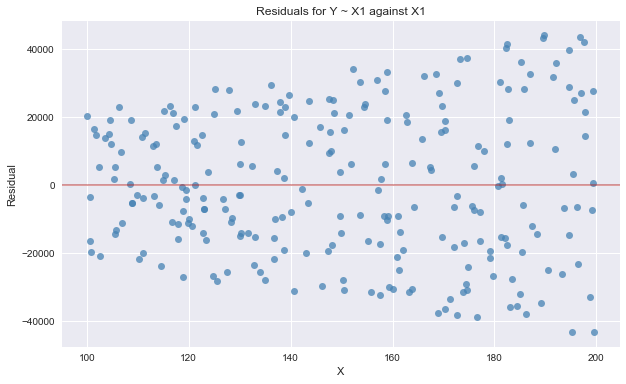

In [11]:
# Generate the data
def experiment_4_data():
    # Betas for our model
    beta_0 = 32.5
    beta_1 = 2.3
    
    # Generate initial sample data
    X1 = generate_uniform_samples(low=100, high=200, size=250)
    X2 = generate_uniform_samples(low=-100, high=100, size=250)
    epsilon = generate_epsilon(stddev=5, size=250)
    Y = [beta_0 + (beta_1 * x1 * x2) + e for x1,x2,e in zip(X1,X2,epsilon)]
    data = pd.DataFrame.from_records(data=zip(Y,X1,X2), columns=['Y','X1', 'X2'])
    
    return data


# Omit X2
def experiment_4_X1_only(data):
    
    # Run the bootstrap
    results = bootstrap_lm(formula='Y ~ X1', data=data)
    print_bootstrap_fit(results)

    # Plot residuals
    formula = results['formula']
    residuals = results['residuals']
    
    scatter_plot_X_Y(X=data['X1'], Y=data['Y'], title='Plot of Y, X1')
    #scatter_plot_X_Y(X=data['X2'], Y=data['Y'], title='Plot of Y, X2')
    
    title = 'Residuals for {0}'.format(formula)
    scatter_plot_residuals(residuals = results['residuals'], title=title)
    
    title = 'Residuals for {0} against {1}'.format(formula, 'X1')
    scatter_plot_residuals(residuals = results['residuals'], X=data['X1'], title=title)
        
    
    
# Seed
np.random.seed(SEED)
py_random.seed(SEED)

data = experiment_4_data()


experiment_4_X1_only(data)

**Observations**:
Omitting $X_2$ results in the confidence intervals of our coefficients becoming very large, to the point where we can basically consider those estimates worthless and know that our model is missing something. The estimate of $\beta_1$ is negative (unexpected) and its 95% CI crosses zero, which recommends for removing it from the model. The residual standard error ($\hat{\sigma}$) shows that we're definitely missing a very large variable (or multiple variables) from our linear model.  $R^2$ shows that almost none of the variance in $Y$ can be explained by this model.

The $X,Y$ plot is actually a little more informative beyond just saying the model is bad. There appears to be a non-linear relationship between Y and values of $X_1$.  As $X_1$ increases, the variance in $Y$ increases.  Similarly the plot of residuals against $X_1$ show that our model both under AND over-predicts more as $X_1$ increases. These plots present visual evidence that something else (the omitted $X_2$) is having a compounding affect on how $X_1$ influences $Y$.

Regression:	Y ~ X1 + X2
# of Samples:	100
------------------
Intercept:	-1642.795770952632,	95% CI:[-4949.124174838697, 1823.664752310542]
X1:	10.112306876412468,	95% CI:[-13.066819689676336, 31.51397822244154]
X2:	350.38598654975124,	95% CI:[337.7273867789945, 359.55892085368407]
------------------
Sigma:	4015.087279809808.	95% CI: [ 3635.22731138  4298.69098402]
R^2:	0.9644388705778325.	95% CI: [ 0.95955208  0.97067258]
------------------


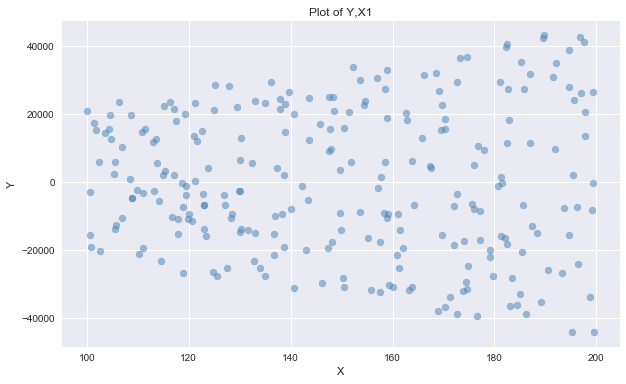

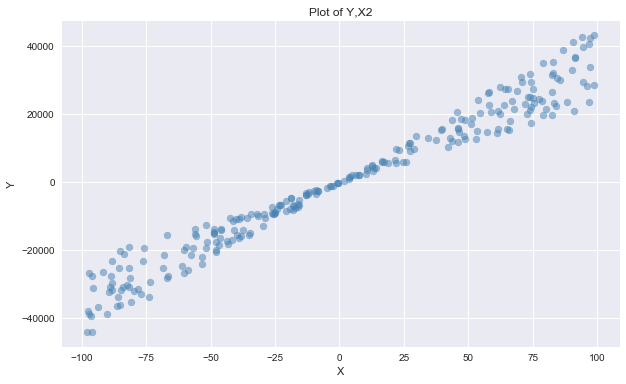

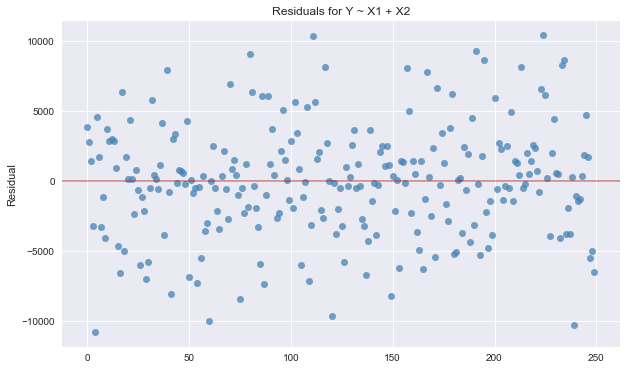

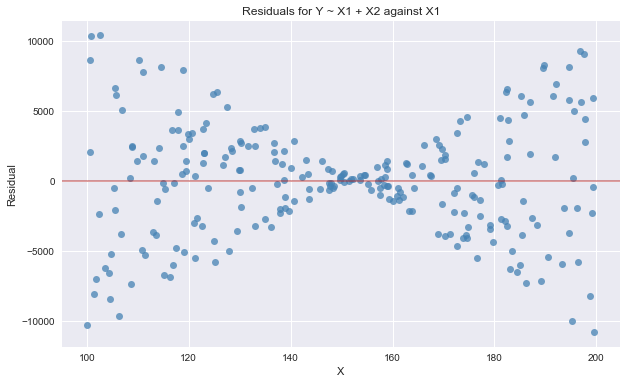

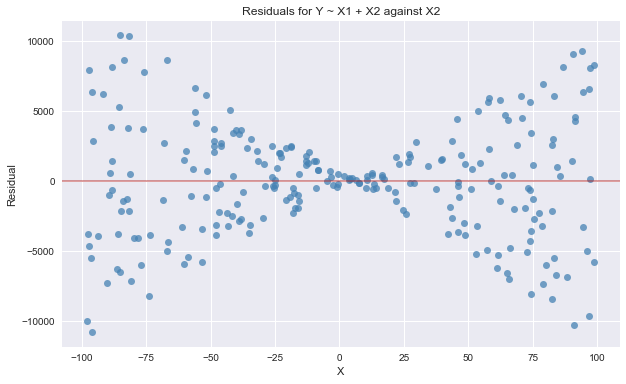

In [12]:
# X1 + X2
def experiment_4_X1_plus_X2(data):
    
    # Run the bootstrap
    results = bootstrap_lm(formula='Y ~ X1 + X2', data=data)
    print_bootstrap_fit(results)
    
    # Plot residuals
    formula = results['formula']
    residuals = results['residuals']
    
    scatter_plot_X_Y(X=data['X1'], Y=data['Y'], title='Plot of Y,X1')
    scatter_plot_X_Y(X=data['X2'], Y=data['Y'], title='Plot of Y,X2')
    
    residuals = results['residuals']
    title = 'Residuals for {0}'.format(formula)
    scatter_plot_residuals(residuals = results['residuals'], title=title)
    
    title = 'Residuals for {0} against {1}'.format(formula, 'X1')
    scatter_plot_residuals(residuals=residuals, X=data['X1'], title=title)
    
    title = 'Residuals for {0} against {1}'.format(formula, 'X2')
    scatter_plot_residuals(residuals=residuals, X=data['X2'], title=title)

# Set random seed
np.random.seed(SEED)
py_random.seed(SEED)

# X1 + X2
experiment_4_X1_plus_X2(data)

**Observations**:
This model's estimates for the coefficients of $X_1$ and $X_2$ become more interesting in comparison to the model using only $X_1$.  Both coefficients are positive (expected) and while $X_1$'s 95% CI crosses 0, it doesn't appear to be hindering the model and should be left in. The coefficient for $X_2$ looks believable (positive & reasonable 95% CI spread) and should be left in.  There is still however considerable deviation between $Y$ and $\hat{Y}$ as show by sigma.  It seems like the $R^2$ value might be missleading here.  It increased signficantly, but perhaps that we just due to the inclusion of an additional predictor $X_2$.

The $X,Y$ plot against $X_2$ shows a strong positive correlation.  As $X_2$ increases, $Y$ increases. The residual plots against $X_1$ and $X_2$ are now more telling. Both have an obvious 'center', then low & high values of $X_1$ and $X_2$ show a lot more under & overprediction.


Regression:	Y ~ X3
# of Samples:	100
------------------
Intercept:	32.90126068267143,	95% CI:[32.29237340166323, 33.59675653958169]
X3:	2.2999207892705376,	95% CI:[2.2998511578973373, 2.2999846545021665]
------------------
Sigma:	4.847038659316168.	95% CI: [ 4.41022677  5.17687901]
R^2:	0.9999999479652755.	95% CI: [ 0.99999994  0.99999996]
------------------


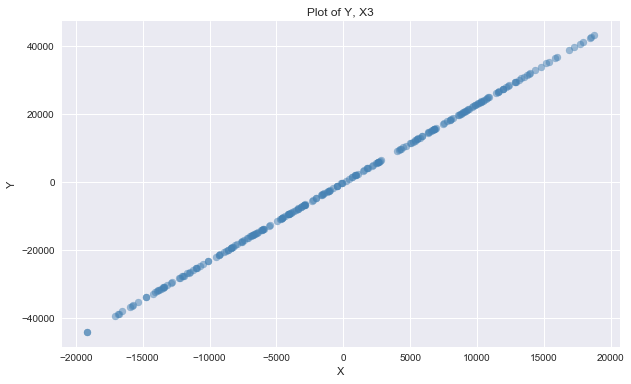

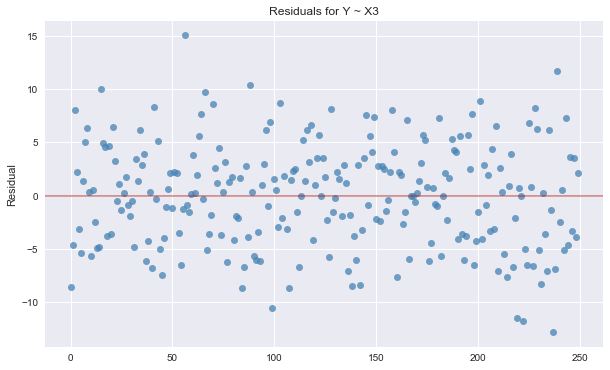

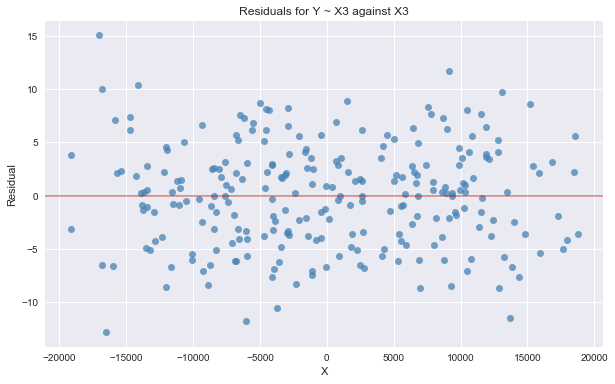

In [13]:
def experiment_4_X3(data):
    
    # Run the bootstrap
    data['X3'] = data['X1'] * data['X2']
    results = bootstrap_lm(formula='Y ~ X3', data=data)
    print_bootstrap_fit(results)
    
    # Plot residuals
    formula = results['formula']
    residuals = results['residuals']
    
    scatter_plot_X_Y(X=data['X3'], Y=data['Y'], title='Plot of Y, X3')
    
    title = 'Residuals for {0}'.format(formula)
    scatter_plot_residuals(residuals=residuals, title=title)

    title = 'Residuals for {0} against {1}'.format(formula, 'X3')
    scatter_plot_residuals(residuals=residuals, X=data['X3'], title=title)
    

# Set SEED
np.random.seed(SEED)
py_random.seed(SEED)
    
# Experiment
experiment_4_X3(data)    

**Observations**:

Introducing the $X_3$ term creates a much better model as we would hope. The coefficient, $\hat{\sigma}$ and $R^2$ are all very believable and point to a _good_ model.  The X,Y plot is perhaps the most telling with a direct linear relationship between $Y$ and $X_3$ being very obvious. The residual plots show much more randomness, lacking correlation with $X_3$.


------

Experiment #5.

Construct a linear model for the multiplicative relationship: 

$Y = 1.2 X_1 * 2 X_2  * 4X_3 * \epsilon$

where:
- $X_1$ is uniformly, randomly distributed over the interval (1, 20)
- $X_2$ is uniformly, randomly distributed over the interval (2, 10)
- $X_3$ is uniformly, randomly distributed over the interval (8, 16)
- $\epsilon$ has $\sigma = 1.5$

Construct your first linear model assuming an additive relationship $Y \sim X_1 + X_2 + X3$.  Is it clear that assuming an additive relationship is not correct? Construct your second model again using an additive relationship, but transform your predictors and regressand appropriately.

Regression:	Y ~ X1 + X2 + X3
# of Samples:	100
------------------
Intercept:	-15389.772395366796,	95% CI:[-17252.700098226167, -13606.543077062768]
X1:	704.0932711010682,	95% CI:[643.4863595287557, 771.994996298934]
X2:	1249.1163599989427,	95% CI:[1139.3692102831035, 1384.5155423270865]
X3:	644.39987273871,	95% CI:[532.8771834766678, 746.9960120019925]
------------------
Sigma:	1813.339104089078.	95% CI: [ 1561.16890301  2004.60382441]
R^2:	0.8845288364635078.	95% CI: [ 0.86449651  0.90685216]
------------------


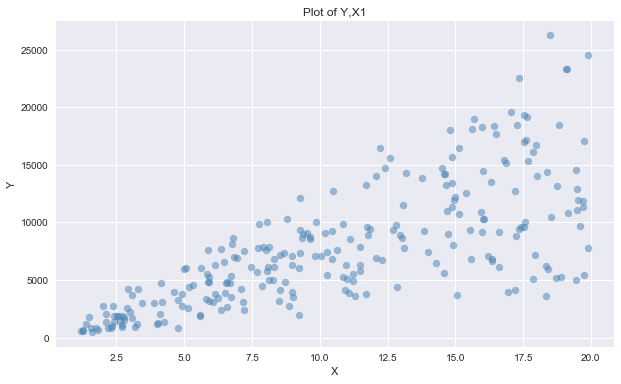

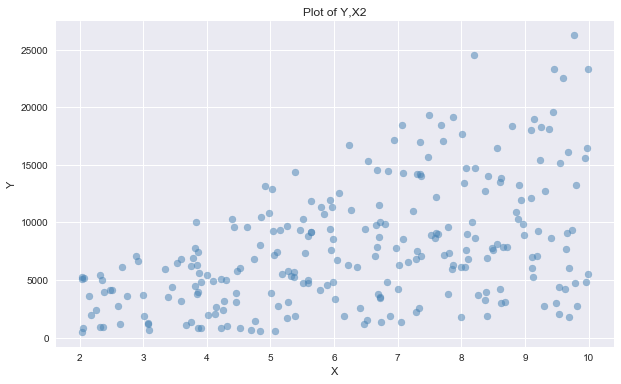

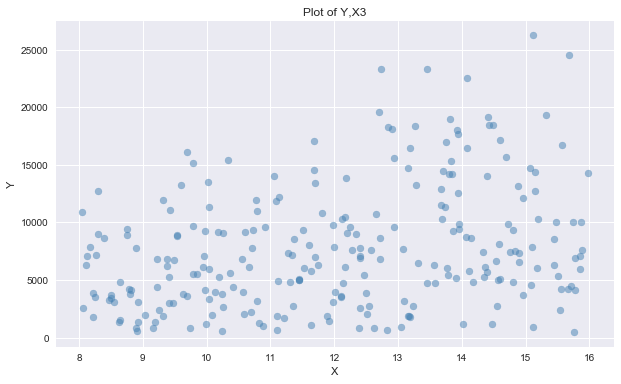

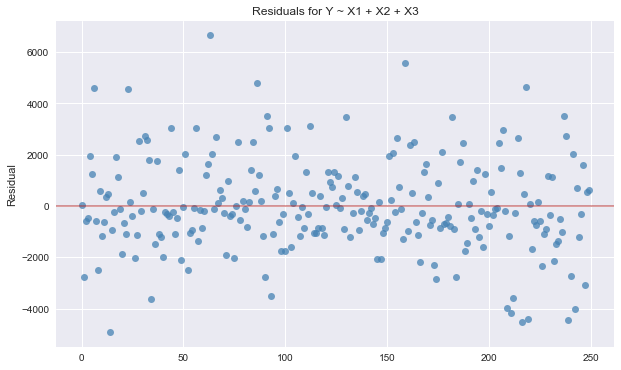

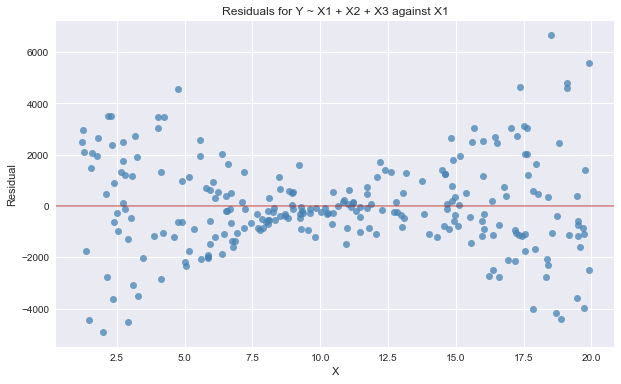

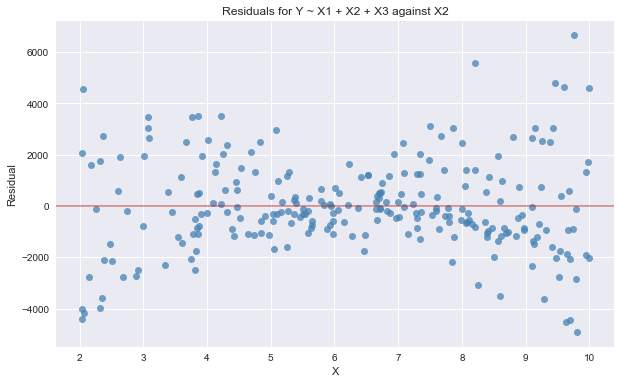

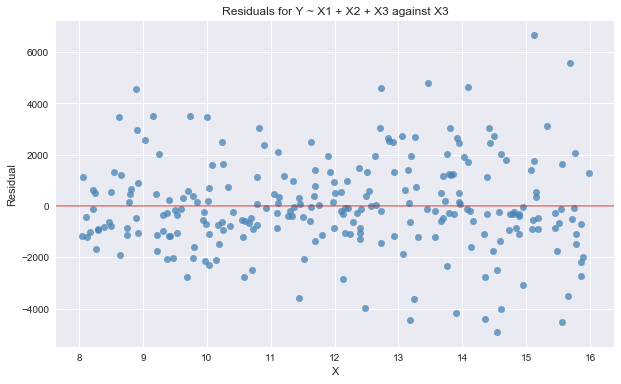

In [14]:
def experiment_5_data():
    beta_0 = 1.2
    beta_1 = 2
    beta_2 = 4
    
    epsilon = generate_epsilon(stddev=1.5, size=250)
    X1 = generate_uniform_samples(low=1, high=20, size=250)
    X2 = generate_uniform_samples(low=2, high=10, size=250)
    X3 = generate_uniform_samples(low=8, high=16, size=250)
    
    Y = [(beta_0 * x1) * (beta_1 * x2) * (beta_2 * x3) + e for x1,x2,x3,e in zip(X1,X2,X3,epsilon)]
    data = pd.DataFrame.from_records(data=zip(Y,X1,X2,X3), columns=['Y','X1','X2','X3'])
    return data


def experiment_5_additive(data):
    
    # Run the bootstrap
    results = bootstrap_lm(formula='Y ~ X1 + X2 + X3', data=data)
    print_bootstrap_fit(results)
    
    # Plot residuals
    formula = results['formula']
    residuals = results['residuals']
    
    scatter_plot_X_Y(X=data['X1'], Y=data['Y'], title='Plot of Y,X1')
    scatter_plot_X_Y(X=data['X2'], Y=data['Y'], title='Plot of Y,X2')
    scatter_plot_X_Y(X=data['X3'], Y=data['Y'], title='Plot of Y,X3')
    
    residuals = results['residuals']
    title = 'Residuals for {0}'.format(formula)
    scatter_plot_residuals(residuals = results['residuals'], title=title)
    
    title = 'Residuals for {0} against {1}'.format(formula, 'X1')
    scatter_plot_residuals(residuals=residuals, X=data['X1'], title=title)
    
    title = 'Residuals for {0} against {1}'.format(formula, 'X2')
    scatter_plot_residuals(residuals=residuals, X=data['X2'], title=title)
    
    title = 'Residuals for {0} against {1}'.format(formula, 'X3')
    scatter_plot_residuals(residuals=residuals, X=data['X3'], title=title)
    
    
# Seed
py_random.seed(SEED)
np.random.seed(SEED)

data = experiment_5_data()
experiment_5_additive(data=data)

**Observations**:
On first looking at the results, the estimates and 95% CI for each of our coefficients of $X_1, X_2, X_3$ look believable, in that they are positive (expected) and reasonably narrow.  The intercept is concerning in that its such a large negative value.  The quality of the model drops considerably when we look at $\hat{\sigma}$, which is showing a considerable amount of unexplained variance between actual and predicted values of $Y$. The X,Y plots against $X_1, X_2, X_3$ respectively show that Y is not just a linear relationship against each, but that there may indeed be some multiplicative effect. The residual plots against each of $X_1, X_2, and X_3$ show that we're over-predicting, with more negative residual values showing up than positive. These results enforce the notion that an additive relationship doesn't look correct.

Regression:	log_y ~ log_x1 + log_x2 + log_x3
# of Samples:	100
------------------
Intercept:	2.2622809671327335,	95% CI:[2.261460096917058, 2.2630482514146815]
log_x1:	0.9999437630860621,	95% CI:[0.9997793133994359, 1.0001059315985013]
log_x2:	0.9999926382001956,	95% CI:[0.9998041145102123, 1.0001871524484645]
log_x3:	0.9998544673836988,	95% CI:[0.9995606954767249, 1.0001711172926795]
------------------
Sigma:	0.0005040801977566854.	95% CI: [ 0.000379    0.00064007]
R^2:	0.999999644734895.	95% CI: [ 0.99999943  0.99999978]
------------------


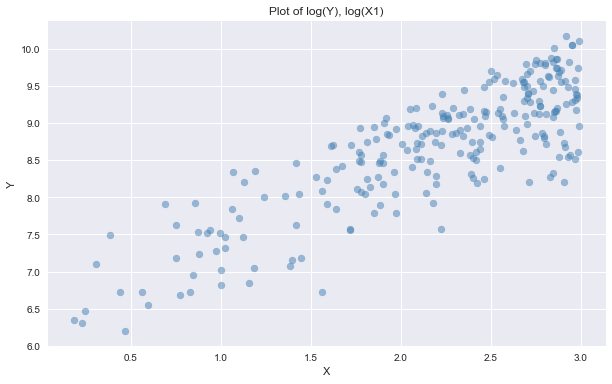

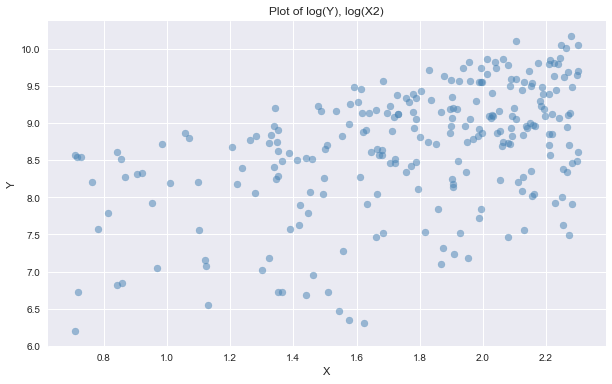

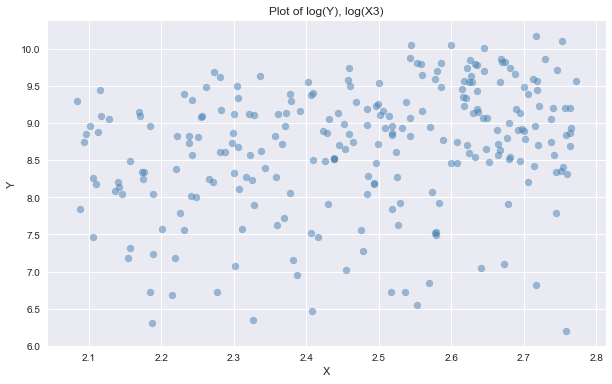

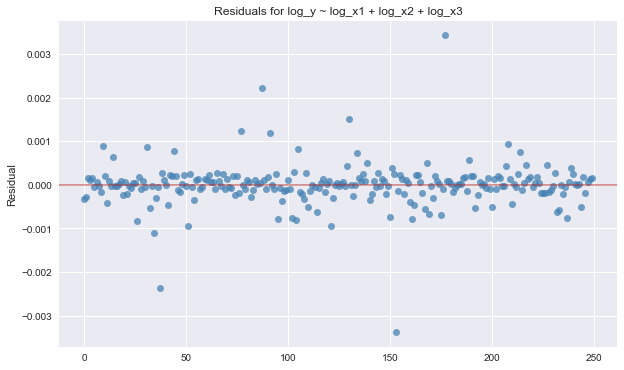

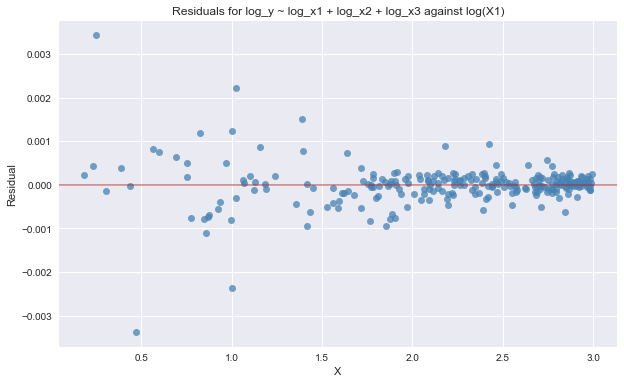

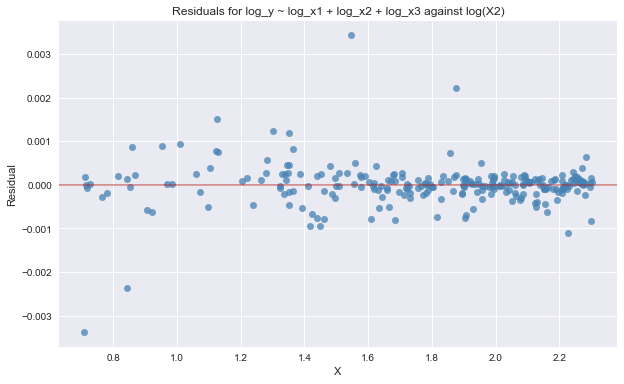

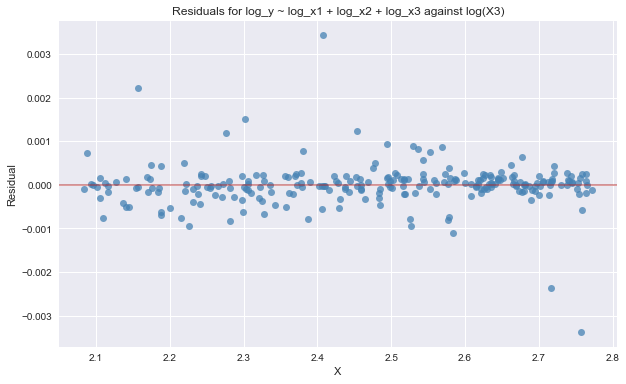

In [15]:
def experiment_5_multiplicative(data):
    
    # Convert to log terms
    def log(x):
        return np.log(float(x))
    
    data['log_y'] = data['Y'].apply(log)
    data['log_x1'] = data['X1'].apply(log)
    data['log_x2'] = data['X2'].apply(log)
    data['log_x3'] = data['X3'].apply(log)
    
    # Run the bootstrap
    results = bootstrap_lm(formula='log_y ~ log_x1 + log_x2 + log_x3', data=data)
    print_bootstrap_fit(results)
    
    # Plot residuals
    formula = results['formula']
    residuals = results['residuals']
    
    scatter_plot_X_Y(X=data['log_x1'], Y=data['log_y'], title='Plot of log(Y), log(X1)')
    scatter_plot_X_Y(X=data['log_x2'], Y=data['log_y'], title='Plot of log(Y), log(X2)')
    scatter_plot_X_Y(X=data['log_x3'], Y=data['log_y'], title='Plot of log(Y), log(X3)')
    
    residuals = results['residuals']
    title = 'Residuals for {0}'.format(formula)
    scatter_plot_residuals(residuals = results['residuals'], title=title)
    
    title = 'Residuals for {0} against {1}'.format(formula, 'log(X1)')
    scatter_plot_residuals(residuals=residuals, X=data['log_x1'], title=title)
    
    title = 'Residuals for {0} against {1}'.format(formula, 'log(X2)')
    scatter_plot_residuals(residuals=residuals, X=data['log_x2'], title=title)
    
    title = 'Residuals for {0} against {1}'.format(formula, 'log(X3)')
    scatter_plot_residuals(residuals=residuals, X=data['log_x3'], title=title)
    

py_random.seed(SEED)
np.random.seed(SEED)
experiment_5_multiplicative(data)

**Observations**: 
As expected, converting to a multiplicative model is reflected in the results and plots. The use of log terms has resulted in tighter confidence intervals, virtually eliminted error $\hat{\sigma}$ and an $R^2$ stating almost all of the variance has been explained.  The X, Y plots are hinting at more of a postive linear relationship in the terms, and the residuals appear uncorrelated to $X_1, X_2, X_3$. 

**References:**

_[1] Module 7 - Code Examples_